In [1]:
# Requirements: python >= 3.0; Pytorch >= 2.0.0 

# pip install TotalSegmentator 

# Next, please get an academic license for TotalSegmentator (we need it to process the task "appendicular_bones") - should be done in a few seconds! 
# https://backend.totalsegmentator.com/license-academic/
# Original GitHub site containing license information: 
# https://github.com/wasserth/TotalSegmentator#:~:text=Available%20with%20a%20license%20(free%20licenses%20available%20for%20non%2Dcommercial%20usage%20here.%20For%20a%20commercial%20license%20contact%20jakob.wasserthal%40usb.ch)%3A

# Set your license, following email instructions 
# totalseg_set_license -l <your-license-number>

# Download weights of the pre-trained model
# totalseg_download_weights -t total [femur_left, femur_right]
# totalseg_download_weights -t appendicular_bones [patella, tibia, fibula]

In [2]:
import time
import subprocess
import numpy as np
import SimpleITK as sitk 

from scipy.ndimage import uniform_filter
from skimage.filters import threshold_otsu

import pydicom 
import os 
from typing import Tuple, Literal 

# Input and output directories
ct_dir = "/mnt/c/users/avery/Desktop/PI201/DICOM/P0000001/ST000001/SE000003"  # Input CT directory 
seg_dir = "/mnt/c/users/avery/Desktop/segmentation_masks"  # Output segmentation masks directory

In [ ]:
# TotalSegmentator 

# Commands to run segmentations for trained classes 
command_total = f"TotalSegmentator -i {ct_dir} -o {seg_dir} --ta total" # "total"
command_appendicular = f"TotalSegmentator -i {ct_dir} -o {seg_dir} --ta appendicular_bones" # "appendicular_bones"

# Record starting time
start_time = time.time()

# Run first command (femurs)
print("Running segmentation with '--ta total'...")
result_total = subprocess.run(command_total, shell=True, capture_output=True, text=True)
if result_total.stderr:
    print("Errors:")
    print(result_total.stderr)
print("Finished '--ta total' segmentation./n")

# Run second command (patella, tibia, fibula)
print("Running segmentation with '--ta appendicular_bones'...")
result_appendicular = subprocess.run(command_appendicular, shell=True, capture_output=True, text=True)
if result_appendicular.stderr:
    print("Errors:")
    print(result_appendicular.stderr)
print("Finished '--ta appendicular_bones' segmentation./n")

# Display time elapsed
elapsed_time = time.time() - start_time
print(f"Total elapsed time: {elapsed_time:.2f} seconds")


Running segmentation with '--ta total'...
Errors:

  0%|          | 0/8 [00:00<?, ?it/s]/home/avery/torchenv/lib/python3.12/site-packages/torch/nn/modules/conv.py:605: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv3d(

100%|██████████| 8/8 [00:03<00:00,  2.16it/s]

100%|██████████| 8/8 [00:01<00:00,  4.11it/s]

100%|██████████| 8/8 [00:00<00:00,  8.30it/s]

100%|██████████| 8/8 [00:01<00:00,  4.65it/s]

100%|██████████| 8/8 [00:01<00:00,  4.71it/s]

Finished '--ta total' segmentation./n
Running segmentation with '--ta appendicular_bones'...
Errors:

  0%|          | 0/8 [00:00<?, ?it/s]/home/avery/torchenv/lib/python3.12/site-packages/torch/nn/modules/conv.py:605: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv3d(

100%|██████████| 8/8 [00:03<00:00,  2.33it/s]

Finished '--ta 

In [ ]:
def refine_mask_adaptive_otsu(mask_path, ct_path, output_path,
                               window_size=2, dilation_radius=3, erosion_radius=1, min_component_size=500, gaussian_sigma=2.0):
    """
    Refine segmentation using adaptive thresholding with Otsu-derived HU threshold.
    
    Parameters:
        mask_path (str): Path to segmentation mask
        ct_path (str): Path to CT scan in HU
        output_path (str): Where to save the refined mask
        window_size (int): Size of cube for adaptive mean filter
        erosion_radius (int): Core erosion to preserve center
        min_component_size (int): Minimum voxels to keep in connected components
        gaussian_sigma (float): Sigma for smoothing CT before Otsu
    """

    # --- Load mask and CT ---
    mask = sitk.ReadImage(mask_path)

    print("Loading mask from {mask_path}")

    # Resample CT to mask geometry
    resample = sitk.ResampleImageFilter()
    resample.SetReferenceImage(mask)
    resample.SetInterpolator(sitk.sitkNearestNeighbor)
    ct_aligned = resample.Execute(ct_path)

    # Smooth CT to suppress noise before Otsu
    ct_smoothed = sitk.SmoothingRecursiveGaussian(ct_aligned, gaussian_sigma)
    mask_float = sitk.Cast(mask, sitk.sitkFloat32)
    mask_smoothed = sitk.BinaryThreshold(sitk.SmoothingRecursiveGaussian(mask_float, gaussian_sigma),
                                     lowerThreshold=0.5, upperThreshold=1e9,
                                     insideValue=1, outsideValue=0)
    

    # Convert arrays
    ct_np = sitk.GetArrayFromImage(ct_smoothed)
    mask_np = sitk.GetArrayFromImage(mask)

    # --- Step 1: Define shell for Otsu and adaptive filtering ---
    dilated = sitk.BinaryDilate(mask, [dilation_radius]*3)
    dilated_np = sitk.GetArrayFromImage(dilated)

    # Apply Otsu threshold only inside the dilated mask
    ct_in_dilated = ct_np[dilated_np > 0]
    if ct_in_dilated.size < 20:
        print("Insufficient points in bone region for Otsu thresholding. Skipping.")
        return

    otsu_hu_thresh = threshold_otsu(ct_in_dilated)
    print(f"[Otsu] HU threshold inside boundary: {otsu_hu_thresh:.1f}")

    # --- Step 2: Adaptive local HU filtering ---
    local_mean = uniform_filter(ct_np, size=window_size)
    refined_np = (dilated_np > 0) & (local_mean > otsu_hu_thresh)

    # --- Step 3: Remove speckles ---
    refined_img = sitk.GetImageFromArray(refined_np.astype(np.uint8))
    refined_img.CopyInformation(mask)
    cc = sitk.ConnectedComponent(refined_img)

    label_stats = sitk.LabelShapeStatisticsImageFilter()
    label_stats.Execute(cc)

    cc_np = sitk.GetArrayFromImage(cc)
    cleaned_np = np.zeros_like(refined_np)
    for l in label_stats.GetLabels():
        if label_stats.GetNumberOfPixels(l) > min_component_size:
            cleaned_np[cc_np == l] = 1

    # --- Step 4: Preserve interior core ---
    eroded = sitk.BinaryErode(mask_smoothed, [erosion_radius]*3)
    eroded_np = sitk.GetArrayFromImage(eroded)

    final_combined = np.logical_or(eroded_np, cleaned_np)

    # --- Step 5: Save output ---
    final_img = sitk.GetImageFromArray(final_combined.astype(np.uint8))
    final_img.CopyInformation(mask)
    sitk.WriteImage(final_img, output_path)

    print(f"Hybrid Otsu-adaptive refined mask saved to {output_path}")


In [ ]:
# Load CT volume from DICOM or NIFTI, output 3D array attributes as part of Tuple[?]
def load_ct_volume(dir_path: str) -> np.ndarray:  
    """
    to update comment 
    make sure function handles error warning for invalid file types or empty files
    Args:
        dir_path (str): Path to DICOM folder or NIFTI (.nii or .nii.gz) file 
    Returns: 
        ct_volume (np.ndarray): 3D array of dimensions (h, w, n_slices), stacked along normal (imaging) axis 
    """
    
    # DICOM (.dcm)
    if not os.listdir(dir_path):
        raise RuntimeError("No files in directory")
    
    proj = [] # compute projection along normal (imaging) axis for each slice 

    for f in os.scandir(dir_path):
        if not f.is_file():
            continue 
        slice = pydicom.dcmread(f.path, stop_before_pixels=True) # Stop before reading full CT file 
        ipp = np.array(slice.ImagePositionPatient, float) # image position patient (IPP)
        iop = np.array(slice.ImageOrientationPatient, float) # image orientation patient (IOP)
        row_v, col_v = iop[:3], iop[3:]
        norm_v = np.cross(row_v, col_v) 
        norm_proj = np.dot(norm_v, ipp)
        proj.append((norm_proj, f.path))  # store as tuple (norm_proj, slice) for efficient sorting 
        
        pixel_spacing = slice.PixelSpacing
        spacing = row_v * pixel_spacing[0] + col_v * pixel_spacing[1] + (norm_v / np.linalg.norm(norm_v)) * slice.SliceThickness

    if not proj:
        raise RuntimeError(f"No DICOM files found in {dir_path}")

    proj.sort(key=lambda x: x[0]) # sort by position along normal projection 

    # Construct CT volume by stacking slices along normal (imaging) axis
    volume = []
    for _, file_loc in proj:
        ct = pydicom.dcmread(file_loc)
        volume.append(ct.pixel_array)

    # Stack slices to form (h, w, n_slices) 3D array along normal (imaging) axis 
    # 
    volume = np.stack(volume, axis=2)
    
    return volume 

# NIFTI (.nii or .nii.gz)

# Metadata from DICOM or NIFTI 
# pixel spacing, Slice thickness, IPP, IOP, rows, columns 


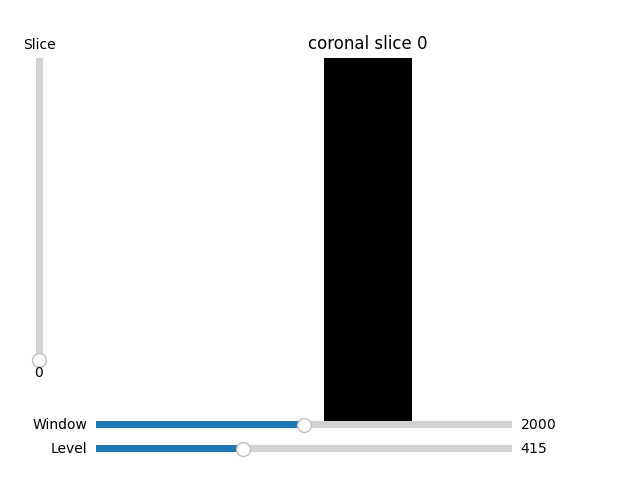

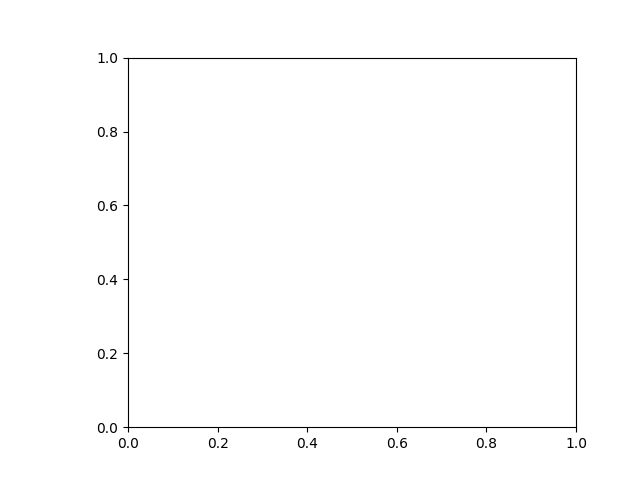

In [ ]:
knee = load_ct_volume(ct_dir)
num, h, w = knee.shape 
fig, ax = plt.subplots()
plt.subplots_adjust(left=0.2)  # leave room for slider

# adjust cmap to normalize across min/max values in ct, to enhance contrast

# function to show location as mouse moves on image? 

def slice_view(volume: np.ndarray, view: Literal['axial', 'coronal','sagittal'], idx: int) -> np.ndarray:
    if len(volume.shape) != 3:
        raise ValueError("CT volume is not 3D")
    # for DICOM (LPH+ system)  
    if view == 'axial': 
        return volume[:,:,idx]
    if view == 'coronal': 
        return volume[:,idx,:]
    if view == 'sagittal':
        return volume[idx,:,:]
    raise ValueError("View must be 'axial', 'coronal' or 'sagittal'")





def window_level_norm(image: np.ndarray, window: float, level: float) -> np.ndarray:
    """
    Apply CT-style window/level to a single slice.

    Parameters
    ----------
    image : np.ndarray
        2D array of HU values.
    window : float
        Window width (range of HU mapped to [0,1]).
    level : float
        Window center (peak of the mapping).

    Returns
    -------
    np.ndarray
        Float image in [0,1], ready for imshow(cmap='gray').
    """
    lo = level - window / 2.0
    hi = level + window / 2.0
    # clip
    img_clipped = np.clip(image, lo, hi)
    # normalize to [0,1]
    return (img_clipped - lo) / (hi - lo)


# choose a default window/level, e.g. bone preset:
DEFAULT_WINDOW = 2000.0
DEFAULT_LEVEL  = 415.0

fig, ax = plt.subplots()
plt.subplots_adjust(left=0.25, right=0.9)

# initial normalized image
slice0 = slice_view(knee, 'coronal', 0)
img_norm = window_level_norm(slice0, DEFAULT_WINDOW, DEFAULT_LEVEL)
im = ax.imshow(img_norm, cmap='gray', vmin=0, vmax=1, aspect=(1.0/0.485))
ax.set_title('coronal slice 0')
ax.axis('off')

# slider for slice index
axslice = fig.add_axes([0.05, 0.25, 0.0225, 0.63])
slice_slider = Slider(axslice, 'Slice', 0, num-1, valinit=0, valstep=1, orientation='vertical')

# slider for window
axwin = fig.add_axes([0.15, 0.1, 0.65, 0.03])
win_slider = Slider(axwin, 'Window', 1, 4000, valinit=DEFAULT_WINDOW)

# slider for level
axlev = fig.add_axes([0.15, 0.05, 0.65, 0.03])
lev_slider = Slider(axlev, 'Level', -1000, 3000, valinit=DEFAULT_LEVEL)

def update(_):
    idx = int(slice_slider.val)
    w   = win_slider.val
    l   = lev_slider.val
    sl  = slice_view(knee, 'coronal', idx)
    sl = sl.T
    sl = np.flipud(sl) 
    ax.imshow(sl, cmap='gray', aspect=(1.0/0.485))
    im.set_data(window_level_norm(sl, w, l))
    ax.set_title(f'Slice {idx}   W={w:.0f}, L={l:.0f}')
    fig.canvas.draw_idle()

# connect all sliders
slice_slider.on_changed(update)
win_slider.on_changed(update)
lev_slider.on_changed(update)

plt.show()
